In [65]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [87]:
img = cv2.imread('rbhavan.jpg',0)

In [88]:
def get_angle_direction(angle):
    """
    Converts angle to degrees and classified into 4 directions; vertical, horizontal and two diagonal directions
    
    Parameters
    -------------
    1. angle : float - angle in radians
    
    Return value
    --------------
    Angle in degrees
    
    """
    angle = np.rad2deg(angle)%180
    
    VERTICAL_CUT = 22.5
    DIAGONAL_CUT = 45
    if angle <= VERTICAL_CUT or angle >= 180 - VERTICAL_CUT:
        direction = 0
    elif angle <= VERTICAL_CUT + DIAGONAL_CUT:
        direction = 45
    elif angle <=VERTICAL_CUT + 2*DIAGONAL_CUT:
        direction = 90
    else:
        direction = 135
    
    return direction

In [89]:
def non_maximum_suppression(image,edge_angle):
    """
    Removes any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a 
    local maximum in its neighborhood in the direction of gradient.
    
    Parameters
    -------------
    1. image      : ndarray - gradient intensity image
    2. edge_angle : ndarray - gradient orientation image
    
    Return value
    --------------
    Suppressed image
    
    """
    rows,cols = image.shape
    suppression = np.zeros((rows,cols),dtype=np.int32)
    
    #Ignoring the boundary pixels. Consider later

    for i in range(rows):
        for j in range(cols):

            if i==0 or j==0 or i==rows-1 or j==cols -1:
                continue
            
            direction = get_angle_direction(edge_angle[i][j])

            if direction == 0 and image[i][j] >= image[i][j-1] and image[i][j] >= image[i][j+1]:
                suppression[i][j] = image[i][j]
            elif direction ==45 and image[i][j] >= image[i-1][j+1] and image[i][j] >= image[i+1][j-1]:
                suppression[i][j] = image[i][j]
            elif direction == 90 and image[i][j] >= image[i+1][j] and image[i][j] >= image[i-1][j]:
                suppression[i][j] = image[i][j]
            elif direction == 135 and image[i][j] >= image[i-1][j-1] and image[i][j] >= image[i+1][j+1]:
                suppression[i][j] = image[i][j]
                               
    return suppression
    

In [90]:
def get_gradient(image,ksize):
    """
    Returns gradient intensity and orientation of 'image' using sobel operator of size 'ksize'
    """
    #Sobel operations
    sobelX = cv2.Sobel(blured_img,cv2.CV_64F,1,0,ksize=ksize)
    sobelY = cv2.Sobel(blured_img,cv2.CV_64F,0,1,ksize=ksize)
    
    #Calculating gradient intensity and orientation
    edge_gradient = np.hypot(sobelX,sobelY)
    edge_angle = np.arctan2(sobelY,sobelX)
    
    return edge_gradient,edge_angle

In [91]:
def Canny(image,minVal,maxVal,ksize=3,Gaus_R=5,Gaus_C=5):
    """
    Finds the edges in an image
    
    Steps involved:
    1. Noise reduction using Gaussian filter
    2. Finding intensity gradient of the image using Sobel kernels
    3. Non-maximum suppression to remove unwanted pixels
    4. Hysteresis thresholding to get the strong edges
    
    Parameters
    --------------
    1. image   : ndarray input - image
    2. minVal  : Integer  -  first threshold for the hysteresis procedure
    3. maxVal  : Integer  -  second threshold for the hysteresis procedure
    4. ksize   : Integer  -  kernel size for the Sobel operator. (Default = 3)
    
    Return value
    --------------
    Binary edge image
    
    """
    
    #Noise reduction using Gaussian filter
    blured_img = cv2.GaussianBlur(img,(Gaus_R,Gaus_C),0)
    
    #Finding intensity gradient of the image using Sobel kernels
    edge_gradient,edge_angle = get_gradient(image,ksize)
    
    #Non-maximum suppression to remove unwanted pixels
    suppressed_edge_img = non_maximum_suppression(edge_gradient,edge_angle)
    
    #Hysteresis thresholding to get the strong edges
    h_thresh_image = hysteresis_threshold(suppressed_edge_img,minVal,maxVal)
    
    return h_thresh_image


In [92]:
def hysteresis_threshold(image,minVal,maxVal):
    """
    Decides which are all edges are really edges and which are not
    
    Parameters
    -------------
    1. image  : ndarray - suppressed edge image
    2. minVal  : Integer  -  first threshold for the hysteresis procedure
    3. maxVal  : Integer  -  second threshold for the hysteresis procedure
    
    Return value
    -------------------
    Image with only strong edges
    """
    
    WEAK_EDGE = 100
    STRONG_EDGE = 255
    
    if minVal>maxVal:
        raise ValueError("minVal should be less than or equal to maxVal")
    
    image[image > maxVal] = STRONG_EDGE
    image[np.logical_and(image >= minVal, image <= maxVal)] = WEAK_EDGE
    image[image < minVal] = 0
    
    row,cols = image.shape
    for i in range(row):
        for j in range(cols):
            if image[i][j] == WEAK_EDGE:
                try:
                    if STRONG_EDGE in [image[i+1][j],image[i-1][j],image[i][j+1],image[i][j-1],image[i+1][j+1],image[i-1][j-1],image[i+1][j-1],image[i-1][j+1]]:
                        image[i][j] = STRONG_EDGE
                    else:
                        image[i][j] = 0
                except IndexError as error:
                    pass
    return image
    
    

True

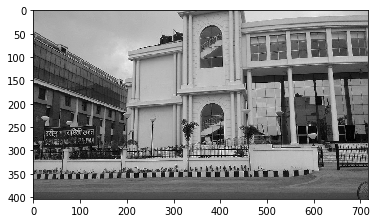

In [93]:
plt.imshow(img,cmap='gray')
cv2.imwrite('grayscale.png',img)

In [94]:
blured_img = cv2.GaussianBlur(img,(5,5),0)

True

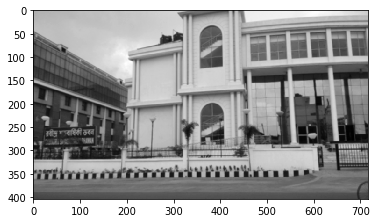

In [95]:
plt.imshow(blured_img,cmap='gray')
cv2.imwrite('blured_image.png',blured_img)

In [112]:
#Sobel operations
sobelX = cv2.Sobel(blured_img,cv2.CV_64F,1,0,ksize=3)
sobelY = cv2.Sobel(blured_img,cv2.CV_64F,0,1,ksize=3)

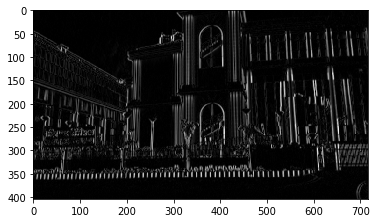

In [113]:
plt.imshow(abs(sobelX),cmap='gray')

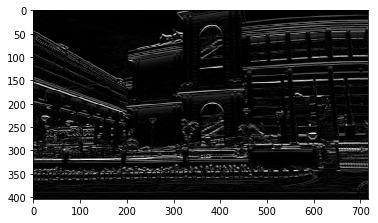

In [114]:
plt.imshow(abs(sobelY),cmap='gray')

True

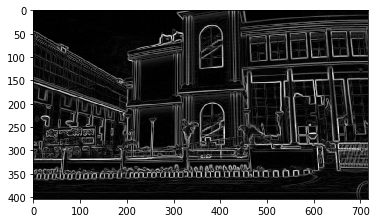

In [115]:
edge_gradient = np.sqrt(np.square(sobelX) + np.square(sobelY))
edge_gradient = np.hypot(sobelX,sobelY)
plt.imshow(edge_gradient,cmap='gray')
cv2.imwrite('gradient_image.png',edge_gradient)

In [116]:
np.max(edge_gradient)

459.05337380309055

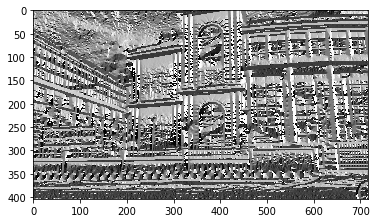

In [100]:
edge_angle = np.arctan2(sobelY,sobelX)
plt.imshow(edge_angle,cmap='gray')

In [101]:
np.rad2deg(edge_angle.min())

-179.84556431062774

True

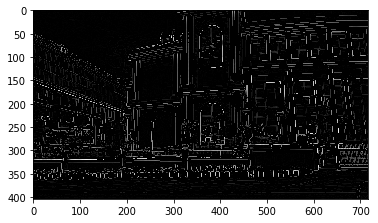

In [102]:
suppressed_edge_img = non_maximum_suppression(edge_gradient,edge_angle)
plt.imshow(suppressed_edge_img,cmap='gray')
cv2.imwrite('suppressed_edge_image.png',suppressed_edge_img)

True

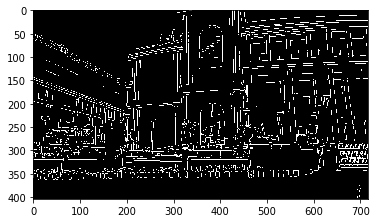

In [103]:
h_thresh_image = hysteresis_threshold(suppressed_edge_img,50,100)
plt.imshow(h_thresh_image,cmap='gray')
cv2.imwrite('hysteresis_thresh_image.png',h_thresh_image)

In [104]:
h_thresh_image = Canny(img,50,100,3)

In [105]:
def edge_classify(edge_image,gradient_image,edge_angle):
    """
    """
    
    rows,cols = edge_image.shape
    edge_color_map = np.zeros((rows,cols,3),dtype=np.uint8)
    
    max_gradient = np.max(gradient_image)
    min_gradient = np.min(gradient_image)
    
    VERT_COLOR = 0
    DIAG_COLOR = 45
    HOR_COLOR = 90
    MDIAG_COLOR = 135
    
    for i in range(rows):
        for j in range(cols):
            try:
                norm_gradient = (255.0 - 0.0)*((1.0*gradient_image[i][j] - min_gradient)/(max_gradient - min_gradient))
            except ZeroDivisionError as error:
                pass
            if edge_image[i][j]:
                direction = get_angle_direction(edge_angle[i][j])
                if direction == 0:
                    edge_color_map[i][j] = [VERT_COLOR,255,norm_gradient]
                elif direction == 45:
                    edge_color_map[i][j] = [DIAG_COLOR,255,norm_gradient]
                elif direction == 90:
                    edge_color_map[i][j] = [HOR_COLOR,255,norm_gradient]
                else:
                    edge_color_map[i][j] = [MDIAG_COLOR,255,norm_gradient]
                
    return cv2.cvtColor(edge_color_map,cv2.COLOR_HSV2RGB)

True

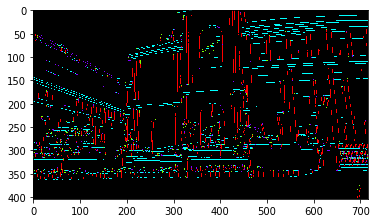

In [106]:
edge_color_map = edge_classify(h_thresh_image,suppressed_edge_img,edge_angle)
plt.imshow(edge_color_map)
cv2.imwrite('edge_color_map.png',edge_color_map)